In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import pickle 
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../Data/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [6]:
df.reset_index(inplace=True)
df.head(10)

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [7]:
df.drop(['index', 'id', 'title', 'author'], axis=1, inplace=True)
df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
lemmatizer = WordNetLemmatizer()
def clean_up(x):
    s = re.sub('[^a-zA-Z]'," ", x)
    stop_words = set(stopwords.words('english'))
    s = re.sub('[^a-zA-Z]'," ", x)
    word_tokens = word_tokenize(s)
    filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words]
    fin = []
    for w in filtered_sentence:
        fin.append(lemmatizer.lemmatize(w))
    return " ".join(fin)

df['text'] = df['text'].apply(lambda x: clean_up(x))

In [9]:
cv = CountVectorizer()
X = cv.fit_transform(df['text'])
Y = df['label']

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.8, random_state = 2)

In [26]:
log_model = LogisticRegression(solver='liblinear', max_iter=5000, C=0.00035)
log_model.fit(X_train, Y_train)
print("average_precision_score for train set: {}".format(accuracy_score(log_model.predict(X_train),Y_train)))
print("average_precision_score for test set: {}".format(accuracy_score(log_model.predict(X_test),Y_test)))


average_precision_score for train set: 0.9248017500683621
average_precision_score for test set: 0.9007383100902379


In [16]:
filename = '../Model/fake_news_model.sav'
pickle.dump(log_model, open(filename, 'wb'))

In [18]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

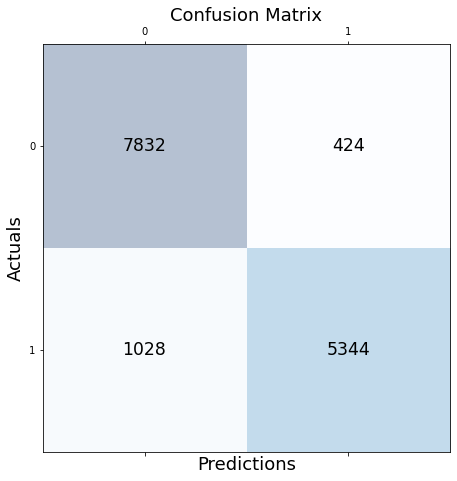

In [27]:
y_pred = loaded_model.predict(X_test)
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

In [31]:
# calculate AUC
auc = roc_auc_score(Y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.894


In [37]:
report = classification_report(Y_test, y_pred, output_dict=True)
classification_report_df = pd.DataFrame(report).transpose()
classification_report_df

,precision,recall,f1-score,support
0,0.883973,0.948643,0.915167,8256.000000
1,0.926491,0.838669,0.880395,6372.000000
accuracy,0.900738,0.900738,0.900738,0.900738
macro avg,0.905232,0.893656,0.897781,14628.000000
weighted avg,0.902494,0.900738,0.900020,14628.000000
